In [143]:
import pandas as pd

df = pd.read_csv("./Input/data/train/train.csv")
df = df.drop(["race"],axis = 1)

# 데이터 전처리
## 여자 -> 남자
ids = ["006359", "006360", "006361", "006362", "006363", "006364"]
df.loc[df[df["id"].isin(ids)].index, "gender"] = "male"

## 남자 -> 여자
ids = ["001498-1", "004432"]
df.loc[df[df["id"].isin(ids)].index, "gender"] = "female"


# 데이터 유효성 검사.
import glob

train_peoples_path = "./Input/data/train/images/*"
people_paths = glob.glob(train_peoples_path)
people_names = [name.split("/")[-1] for name in people_paths ]

#길이 비교
print(len(people_names), len(df["path"]))
#중복 문자열 존재하는지 비교
print(len(set(people_names)), len(set(df["path"])))
#불일치 문자열 존재하는지 체크
print(len(set(people_names) - set(df["path"])))

2700 2700
2700 2700
0


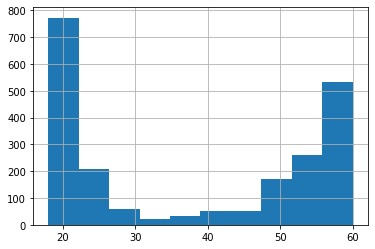

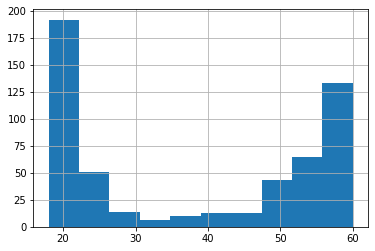

In [144]:
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

raw_data = df
for train_index, test_index in split.split(raw_data, raw_data["age"]):
    strat_train_set = raw_data.loc[train_index]
    strat_test_set = raw_data.loc[test_index]

train_df = strat_train_set
valid_df = strat_test_set
strat_train_set["age"].hist()
plt.show()
strat_test_set["age"].hist()
plt.show()

In [145]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 154 to 19
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2160 non-null   object
 1   gender  2160 non-null   object
 2   age     2160 non-null   int64 
 3   path    2160 non-null   object
dtypes: int64(1), object(3)
memory usage: 84.4+ KB


In [146]:
def labeling(df, folder_path):
    temp = pd.DataFrame()
    
    path_list = []
    full_path_list = [] 
    state_list = []
    for path in df["path"]:
        #사람 폴더에서 이미지 경로 받기.
        imgs = glob.glob(folder_path + "/" + path + "/*")
        
        path_list.extend([path]*7)
        full_path_list.extend([full_path for full_path in imgs])
        state_list.extend([full_path.split("/")[-1].split(".")[0] for full_path in imgs])
  
    temp["path"] = path_list
    temp["img_path"] = full_path_list
    temp["state"] = state_list
    return temp

# 기존 df와 생성된 df 합치기
def merge_df(df, mask_state_df):
    return_df = pd.merge(df, mask_state_df, how= "outer", on = "path")
    # print(return_df)
    return_df.loc[return_df.query("state == 'incorrect_mask'").index, "state"] = "incorrect"

    # 라벨링
    return_df["label"] = 0
    return_df.loc[return_df.query("state == 'incorrect'").index, "label"] += 6
    return_df.loc[return_df.query("state == 'normal'").index, "label"] += 12

    return_df.loc[return_df.query("gender == 'female'").index, "label"] += 3

    return_df.loc[return_df.query("30 <= age < 60 ").index, "label"] += 1
    return_df.loc[return_df.query("age == 60 ").index, "label"] += 2


    # valid_df = return_df.iloc[200:]
    # return_df = return_df.iloc[:200]

    return_df["c_gender"] = 0
    return_df.loc[return_df.query("gender == 'male'").index, "c_gender"] = 1

    return_df["c_state"] = 0
    return_df.loc[return_df.query("state == 'incorrect'").index, "c_state"] = 1
    return_df.loc[return_df.query("state == 'normal'").index, "c_state"] = 2

    return_df["c_age"] = 0
    return_df.loc[return_df.query("30 <= age < 60 ").index, "c_age"] = 1
    return_df.loc[return_df.query("age == 60 ").index, "c_age"] = 2
    
    return_df["c_age_deep"] = 0
    return_df.loc[return_df.query("20 <= age < 25 ").index, "c_age_deep"] = 1
    return_df.loc[return_df.query("25 <= age < 30 ").index, "c_age_deep"] = 2
    return_df.loc[return_df.query("30 <= age < 35 ").index, "c_age_deep"] = 3
    return_df.loc[return_df.query("35 <= age < 40 ").index, "c_age_deep"] = 4
    return_df.loc[return_df.query("40 <= age < 45 ").index, "c_age_deep"] = 5
    return_df.loc[return_df.query("45 <= age < 50 ").index, "c_age_deep"] = 6
    return_df.loc[return_df.query("50 <= age < 55 ").index, "c_age_deep"] = 7
    return_df.loc[return_df.query("55 <= age < 60 ").index, "c_age_deep"] = 8
    return_df.loc[return_df.query("age == 60 ").index, "c_age_deep"] = 9


    label_dict = {0: "마스크쓴 남성 청년",
              1: "마스크쓴 남성 중년",
              2: "마스크쓴 남성 노년",
              3: "마스크쓴 여성 청년",
              4: "마스크쓴 여성 중년",
              5: "마스크쓴 여성 노년",
              
              6: "잘못쓴 남성 청년",
              7: "잘못쓴 남성 중년",
              8: "잘못쓴 남성 노년",
              9: "잘못쓴 여성 청년",
              10: "잘못쓴 여성 중년",
              11: "잘못쓴 여성 노년",
              
              12: "안쓴 남성 청년",
              13: "안쓴 남성 중년",
              14: "안쓴 남성 노년",
              15: "안쓴 여성 청년",
              16: "안쓴 여성 중년",
              17: "안쓴 여성 노년",
    }
    return_df["label_check"] = return_df["label"].replace(label_dict)
    return return_df


mask_state_train_df = labeling(train_df, "Input/data/train/images")  
mask_state_valid_df = labeling(valid_df, "Input/data/train/images")

train_df = merge_df(train_df, mask_state_train_df)
valid_df = merge_df(valid_df, mask_state_valid_df)

valid_df.sample(20)[["gender","age","state","label_check"]]


,gender,age,state,label_check
1364,female,56,mask5,마스크쓴 여성 중년
3541,female,24,mask5,마스크쓴 여성 청년
3513,female,18,mask5,마스크쓴 여성 청년
29,female,50,normal,안쓴 여성 중년
2526,female,20,mask5,마스크쓴 여성 청년
1284,female,55,mask1,마스크쓴 여성 중년
298,male,19,mask5,마스크쓴 남성 청년
1564,male,19,mask1,마스크쓴 남성 청년
686,male,20,normal,안쓴 남성 청년
1141,female,29,mask2,마스크쓴 여성 청년


In [147]:
train_df.head()

,id,gender,age,path,img_path,state,label,c_gender,c_state,c_age,c_age_deep,label_check
0,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask2,4,0,0,1,8,마스크쓴 여성 중년
1,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,normal,16,0,2,1,8,안쓴 여성 중년
2,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask3,4,0,0,1,8,마스크쓴 여성 중년
3,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask1,4,0,0,1,8,마스크쓴 여성 중년
4,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask4,4,0,0,1,8,마스크쓴 여성 중년


In [148]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_folder_name = './Input/data/no_mask/UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())

In [149]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'img_path']
    df = df.dropna()
    
    return df

In [150]:
old_df = parse_dataset(dataset_folder_name)

In [151]:
over_60 = old_df['age'] > 60
is_male = old_df['gender'] == 'male' 
is_female = old_df['gender'] == 'female'
is_asian = old_df['race'] == 'asian'
old_df['state'] = ['normal' for i in old_df.index]
old_df = old_df[over_60 & (is_male | is_female) & is_asian]

# 라벨링
old_df["label"] = 0
old_df.loc[old_df.query("state == 'incorrect'").index, "label"] += 6
old_df.loc[old_df.query("state == 'normal'").index, "label"] += 12

old_df.loc[old_df.query("gender == 'female'").index, "label"] += 3

old_df.loc[old_df.query("30 <= age < 60 ").index, "label"] += 1
old_df.loc[old_df.query("age == 60 ").index, "label"] += 2

old_df["c_gender"] = 0
old_df.loc[old_df.query("gender == 'male'").index, "c_gender"] = 1

old_df["c_state"] = 2
#old_df.loc[old_df.query("state == 'incorrect'").index, "c_state"] = 1
#old_df.loc[old_df.query("state == 'normal'").index, "c_state"] = 2

old_df["c_age"] = 2
old_df.loc[old_df.query("30 <= age < 60 ").index, "c_age"] = 1
old_df.loc[old_df.query("age == 60 ").index, "c_age"] = 2
old_df

,age,gender,race,img_path,state,label,c_gender,c_state,c_age
150,64.0,male,asian,./Input/data/no_mask/UTKFace/64_0_2_2017011619...,normal,12,1,2,2
288,61.0,male,asian,./Input/data/no_mask/UTKFace/61_0_2_2017011222...,normal,12,1,2,2
323,85.0,female,asian,./Input/data/no_mask/UTKFace/85_1_2_2017011018...,normal,15,0,2,2
501,72.0,male,asian,./Input/data/no_mask/UTKFace/72_0_2_2017011222...,normal,12,1,2,2
521,72.0,male,asian,./Input/data/no_mask/UTKFace/72_0_2_2017011220...,normal,12,1,2,2
...,...,...,...,...,...,...,...,...,...
23086,71.0,male,asian,./Input/data/no_mask/UTKFace/71_0_2_2017011222...,normal,12,1,2,2
23110,72.0,male,asian,./Input/data/no_mask/UTKFace/72_0_2_2017010517...,normal,12,1,2,2
23606,80.0,male,asian,./Input/data/no_mask/UTKFace/80_0_2_2017011220...,normal,12,1,2,2
23651,67.0,male,asian,./Input/data/no_mask/UTKFace/67_0_2_2017011619...,normal,12,1,2,2


In [152]:
n_val = int(len(old_df) * 0.2)
n_train = len(old_df) - n_val

train_old_df = old_df.iloc[:n_train,:]
valid_old_df = old_df.iloc[n_train:,:]

In [132]:
len(valid_old_df)

51

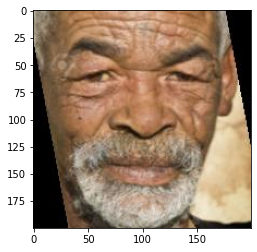

tensor([[[  0.,   0.,   0.,  ..., 153., 151., 149.],
         [  0.,   0.,   0.,  ..., 159., 155., 153.],
         [  0.,   0.,   0.,  ..., 161., 154., 150.],
         ...,
         [224., 224., 225.,  ...,   0.,   0.,   0.],
         [225., 225., 225.,  ...,   0.,   0.,   0.],
         [226., 226., 225.,  ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,  ..., 138., 135., 133.],
         [  0.,   0.,   0.,  ..., 143., 140., 137.],
         [  0.,   0.,   0.,  ..., 145., 139., 134.],
         ...,
         [205., 205., 205.,  ...,   0.,   0.,   0.],
         [205., 205., 205.,  ...,   0.,   0.,   0.],
         [205., 205., 204.,  ...,   0.,   0.,   0.]],

        [[  2.,   2.,   2.,  ..., 115., 111., 108.],
         [  2.,   2.,   2.,  ..., 120., 115., 112.],
         [  2.,   2.,   2.,  ..., 122., 114., 109.],
         ...,
         [161., 161., 161.,  ...,   0.,   0.,   0.],
         [160., 160., 160.,  ...,   0.,   0.,   0.],
         [160., 159., 159.,  ...,   0.,   0.,   0.]]]

In [153]:

raw_image = cv2.imread(valid_old_df["img_path"].iloc[0])
image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
augmented = album_transform(image=image) 
x = augmented['image']
#plt.imshow(x)
#plt.show()
x.float()
#y = torch.tensor(self.df[self.label].iloc[idx])
#z = self.df["path"].iloc[idx] + "_" + self.df["state"].iloc[idx]

In [48]:
len(train_old_df)

205

In [49]:
train_df.iloc[-207:]

,id,gender,age,path,img_path,state,label,c_gender,c_state,c_age,c_age_deep,label_check
14913,001179-1,female,24,001179-1_female_Asian_24,Input/data/train/images/001179-1_female_Asian_...,mask1,3,0,0,0,1,마스크쓴 여성 청년
14914,001179-1,female,24,001179-1_female_Asian_24,Input/data/train/images/001179-1_female_Asian_...,mask4,3,0,0,0,1,마스크쓴 여성 청년
14915,001179-1,female,24,001179-1_female_Asian_24,Input/data/train/images/001179-1_female_Asian_...,incorrect,9,0,1,0,1,잘못쓴 여성 청년
14916,001179-1,female,24,001179-1_female_Asian_24,Input/data/train/images/001179-1_female_Asian_...,mask5,3,0,0,0,1,마스크쓴 여성 청년
14917,001038,male,60,001038_male_Asian_60,Input/data/train/images/001038_male_Asian_60/m...,mask2,2,1,0,2,9,마스크쓴 남성 노년
...,...,...,...,...,...,...,...,...,...,...,...,...
15115,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,mask3,4,0,0,1,8,마스크쓴 여성 중년
15116,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,mask1,4,0,0,1,8,마스크쓴 여성 중년
15117,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,mask4,4,0,0,1,8,마스크쓴 여성 중년
15118,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,incorrect,10,0,1,1,8,잘못쓴 여성 중년


In [50]:
train_df

,id,gender,age,path,img_path,state,label,c_gender,c_state,c_age,c_age_deep,label_check
0,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask2,4,0,0,1,8,마스크쓴 여성 중년
1,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,normal,16,0,2,1,8,안쓴 여성 중년
2,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask3,4,0,0,1,8,마스크쓴 여성 중년
3,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask1,4,0,0,1,8,마스크쓴 여성 중년
4,000531,female,56,000531_female_Asian_56,Input/data/train/images/000531_female_Asian_56...,mask4,4,0,0,1,8,마스크쓴 여성 중년
...,...,...,...,...,...,...,...,...,...,...,...,...
15115,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,mask3,4,0,0,1,8,마스크쓴 여성 중년
15116,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,mask1,4,0,0,1,8,마스크쓴 여성 중년
15117,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,mask4,4,0,0,1,8,마스크쓴 여성 중년
15118,000024,female,58,000024_female_Asian_58,Input/data/train/images/000024_female_Asian_58...,incorrect,10,0,1,1,8,잘못쓴 여성 중년


In [136]:
train_df = pd.concat([train_df,train_old_df])
valid_df = pd.concat([valid_df,valid_old_df])

In [155]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import albumentations as A
import albumentations.pytorch
import cv2

from torchvision import transforms

# transform = transforms.Compose([
#     transforms.CenterCrop((450, 250)),
#     transforms.ToTensor()
#     ,
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Declare an augmentation pipeline
album_transform = A.Compose([
#    A.CenterCrop(width=300, height=350),
#     A.Resize(256,256),
    A.Resize(224,224),

   # A.Resize(320,320),
#     A.ToGray(p=1),
    A.GridDistortion(),
    A.CoarseDropout(),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10),
#     A.RandomBrightnessContrast(p=0.5),
#     A.HueSaturationValue(),
    A.pytorch.transforms.ToTensorV2()
])

valid_transform = A.Compose([
#    A.CenterCrop(width=300, height=350),
#     A.Resize(256,256),
    A.Resize(224,224),

    # A.Resize(320,320),
#     A.ToGray(p=1),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.HueSaturationValue(),
    A.pytorch.transforms.ToTensorV2()
])

class Maskset(Dataset):
    def __init__(self, df, transform, label = "label"):
        self.df = df
        self.transform = transform
        self.label = label
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        raw_image = cv2.imread(self.df["img_path"].iloc[idx])
        image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
        augmented = self.transform(image=image) 
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        x = augmented['image'].float()
        y = torch.tensor(self.df[self.label].iloc[idx])
        return (x/255).type(torch.float), y

In [138]:
valid_df.iloc[-260:]

,id,gender,age,path,img_path,state,label,c_gender,c_state,c_age,c_age_deep,label_check,race
3571,006081,male,19.0,006081_male_Asian_19,Input/data/train/images/006081_male_Asian_19/n...,normal,12,1,2,0,0.0,안쓴 남성 청년,NaN
3572,006081,male,19.0,006081_male_Asian_19,Input/data/train/images/006081_male_Asian_19/m...,mask3,0,1,0,0,0.0,마스크쓴 남성 청년,NaN
3573,006081,male,19.0,006081_male_Asian_19,Input/data/train/images/006081_male_Asian_19/m...,mask1,0,1,0,0,0.0,마스크쓴 남성 청년,NaN
3574,006081,male,19.0,006081_male_Asian_19,Input/data/train/images/006081_male_Asian_19/m...,mask4,0,1,0,0,0.0,마스크쓴 남성 청년,NaN
3575,006081,male,19.0,006081_male_Asian_19,Input/data/train/images/006081_male_Asian_19/i...,incorrect,6,1,1,0,0.0,잘못쓴 남성 청년,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23086,NaN,male,71.0,NaN,./Input/data/no_mask/UTKFace/71_0_2_2017011222...,normal,12,1,2,2,NaN,NaN,asian
23110,NaN,male,72.0,NaN,./Input/data/no_mask/UTKFace/72_0_2_2017010517...,normal,12,1,2,2,NaN,NaN,asian
23606,NaN,male,80.0,NaN,./Input/data/no_mask/UTKFace/80_0_2_2017011220...,normal,12,1,2,2,NaN,NaN,asian
23651,NaN,male,67.0,NaN,./Input/data/no_mask/UTKFace/67_0_2_2017011619...,normal,12,1,2,2,NaN,NaN,asian


In [139]:
import numpy as np
from torch.utils.data import WeightedRandomSampler
import torch

labes_unique, counts = np.unique(train_df["label"], return_counts = True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in train_df["label"]]
sampler = WeightedRandomSampler(example_weights, len(train_df["label"]))
# class_weights

BATCH_SIZE = 128
train_set_dict = {}
valid_set_dict = {}
train_loader_dict = {}
valid_loader_dict = {}

for label in ["label", "c_age", "c_gender", "c_state", "c_age_deep"]:    
    train_set_dict[label] = Maskset(train_df, album_transform, label)
    valid_set_dict[label] = Maskset(valid_df, valid_transform, label)

    train_loader_dict[label] = DataLoader(train_set_dict[label], num_workers=4, batch_size=BATCH_SIZE, drop_last = True, sampler = sampler)
    valid_loader_dict[label] = DataLoader(valid_set_dict[label], num_workers=4, batch_size=BATCH_SIZE, drop_last = True, shuffle=True)

In [140]:
print(len(train_loader_dict["label"].dataset), len(valid_loader_dict["label"].dataset))

15376 3780


In [141]:
# age
import timm
from PIL import Image
from torchvision import transforms
from torch import nn
import torchvision.models as models
import torch
from tqdm.notebook import tqdm 
import datetime

import math

from torch import optim

from sklearn.metrics import f1_score

NUM_EPOCH = 40
LEARNING_RATE = 0.0005

def train_model(model, train_loader, valid_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()   # 비용 함수에 소프트맥스 함수 포함되어져 있음.
#     optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
    optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
    best_test_accuracy = 0.
    best_test_loss = 9999.

    for epoch in range(NUM_EPOCH):
        running_loss = 0.
        running_acc = 0.
        epoch_f1 = 0

        model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함

        for ind, (images, labels) in enumerate(tqdm(train_loader)):
          
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함
            logits = model(images)
            _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
            loss = loss_fn(logits, labels)
            loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
            optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
            scheduler.step() 

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels) # 한 Batch에서의 Accuracy 값 저장
            epoch_f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_acc / len(train_loader.dataset)
        epoch_f1 = epoch_f1/ind

        print(f"현재 epoch-{epoch}의 train-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}, 평균 f1 : {epoch_f1:.4f}\n\n")

        model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
        running_acc = 0.
        epoch_f1 = 0
        
        with torch.no_grad():
            pred_list = []
            label_list = []
            path_list = []
            for ind, (images, labels) in enumerate(tqdm(valid_loader)):
                
                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  

                running_acc += torch.sum(preds == labels) # 한 Batch에서의 Accuracy 값 저장
                pred_list.extend(preds.cpu().tolist())
                label_list.extend(labels.cpu().tolist())
                
            epoch_f1 = f1_score(label_list, pred_list , average='macro')
            epoch_acc = running_acc / len(valid_loader.dataset)
        
        valid_result = pd.DataFrame()
        valid_result["pred"] = np.squeeze(np.array(pred_list))
        valid_result["label"] = np.squeeze(np.array(label_list))
        now = datetime.datetime.now().strftime('%m%d_%H%M')
        valid_result.to_csv(f"{epoch}_{now}.csv", index =False)
        torch.save(model, f"{epoch_f1}_{epoch}_{now}.pt")
        print(f"현재 epoch-{epoch}의 test-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}, 평균 f1 : {epoch_f1:.4f}\n\n")
        
#         if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
#             best_test_accuracy = epoch_acc
#         if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
#             best_test_loss = epoch_loss
#     print("학습 종료!")
#     print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

    return model

In [159]:
label = "c_age"
age_model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes= 3)
age_model = train_model(age_model, train_loader_dict[label],  valid_loader_dict[label])


현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.189, 평균 Accuracy : 0.926, 평균 f1 : 0.9335





현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.189, 평균 Accuracy : 0.862, 평균 f1 : 0.7373





현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.058, 평균 Accuracy : 0.979, 평균 f1 : 0.9879





현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.058, 평균 Accuracy : 0.793, 평균 f1 : 0.7204





현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.042, 평균 Accuracy : 0.984, 평균 f1 : 0.9932





현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.042, 평균 Accuracy : 0.847, 평균 f1 : 0.7643





현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.024, 평균 Accuracy : 0.991, 평균 f1 : 1.0004





현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.024, 평균 Accuracy : 0.860, 평균 f1 : 0.7969





현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.041, 평균 Accuracy : 0.986, 평균 f1 : 0.9954





현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.041, 평균 Accuracy : 0.889, 평균 f1 : 0.8043





현재 epoch-5의 train-데이터 셋에서 평균 Loss : 0.023, 평균 Accuracy : 0.992, 평균 f1 : 1.0011





현재 epoch-5의 test-데이터 셋에서 평균 Loss : 0.023, 평균 Accuracy : 0.881, 평균 f1 : 0.7879





현재 epoch-6의 train-데이터 셋에서 평균 Loss : 0.016, 평균 Accuracy : 0.993, 평균 f1 : 1.0024





현재 epoch-6의 test-데이터 셋에서 평균 Loss : 0.016, 평균 Accuracy : 0.873, 평균 f1 : 0.7846





현재 epoch-7의 train-데이터 셋에서 평균 Loss : 0.031, 평균 Accuracy : 0.989, 평균 f1 : 0.9979





현재 epoch-7의 test-데이터 셋에서 평균 Loss : 0.031, 평균 Accuracy : 0.878, 평균 f1 : 0.7953





현재 epoch-8의 train-데이터 셋에서 평균 Loss : 0.018, 평균 Accuracy : 0.993, 평균 f1 : 1.0026





현재 epoch-8의 test-데이터 셋에서 평균 Loss : 0.018, 평균 Accuracy : 0.888, 평균 f1 : 0.8054





현재 epoch-9의 train-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.997, 평균 f1 : 1.0068





현재 epoch-9의 test-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.887, 평균 f1 : 0.7859





현재 epoch-10의 train-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.997, 평균 f1 : 1.0066





현재 epoch-10의 test-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.889, 평균 f1 : 0.7970





현재 epoch-11의 train-데이터 셋에서 평균 Loss : 0.019, 평균 Accuracy : 0.992, 평균 f1 : 1.0017




KeyboardInterrupt: 

In [60]:
label = "c_state"
state_model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes= 3)
state_model = train_model(state_model, train_loader_dict[label],  valid_loader_dict[label])

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-52-b8c1b8c10761>", line 61, in __getitem__
    return (x/255).type(torch.float), y, z
RuntimeError: Integer division of tensors using div or / is no longer supported, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [ ]:
label = "c_gender"
gender_model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes= 2)
gender_model = train_model(gender_model, train_loader_dict[label],  valid_loader_dict[label])

In [ ]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

test_dir = '/opt/ml/data/eval'

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)
    
    
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, valid_transform)
loader = DataLoader(dataset, batch_size = 64 ,shuffle=False)

In [ ]:
model = gender_model
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to("cuda")
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())

submission['gender'] = all_predictions

# # 제출할 파일을 저장합니다.
# submission.to_csv('submission.csv', index=False)
# print('test inference is done!')

In [ ]:
model = age_model
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to("cuda")
        pred = model(images)
        pred = pred.argmax(dim=-1)
        #_, preds = torch.max(logits, 1)
        all_predictions.extend(pred.cpu().numpy())

submission['age'] = all_predictions

In [ ]:
model = state_model
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to("cuda")
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())

submission['state'] = all_predictions

In [ ]:
submission["ans"] = 0
submission.loc[submission.query("state == 1").index, "ans"] += 6
submission.loc[submission.query("state == 2").index, "ans"] += 12

submission.loc[submission.query("gender == 0").index, "ans"] += 3

submission.loc[submission.query("age == 1").index, "ans"] += 1
submission.loc[submission.query("age == 2 ").index, "ans"] += 2


# train_df["label"] = 0
# train_df.loc[train_df.query("state == 'incorrect'").index, "label"] += 6
# train_df.loc[train_df.query("state == 'normal'").index, "label"] += 12

# train_df.loc[train_df.query("gender == 'female'").index, "label"] += 3

# train_df.loc[train_df.query("30 <= age < 60 ").index, "label"] += 1
# train_df.loc[train_df.query("age == 60 ").index, "label"] += 2



# train_df["c_gender"] = 0
# train_df.loc[train_df.query("gender == 'male'").index, "c_gender"] = 1

# train_df["c_state"] = 0
# train_df.loc[train_df.query("state == 'incorrect'").index, "c_state"] = 1
# train_df.loc[train_df.query("state == 'normal'").index, "c_state"] = 2

# train_df["c_age"] = 0
# train_df.loc[train_df.query("30 <= age < 60 ").index, "c_age"] = 1
# train_df.loc[train_df.query("age == 60 ").index, "c_age"] = 2

In [ ]:
submission[["ImageID", "ans"]].to_csv("submission_5.csv", index=False)

In [ ]:
model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes=18)

# model = models.resnext50_32x4d(pretrained=True)
# out_features = model.fc.out_features
# model.last = nn.Linear(out_features, 18)
# torch.nn.init.xavier_uniform_(model.last.weight)
# stdv = 1. / math.sqrt(model.last.weight.size(1))
# model.last.bias.data.uniform_(-stdv, stdv)

dataloaders = {
    "train" : train_loader_dict["label"],
    "test" : valid_loader_dict["label"]
}

loss_fn = torch.nn.CrossEntropyLoss()   # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)

scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

        for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = model(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  

                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
                    scheduler.step() 

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels) # 한 Batch에서의 Accuracy 값 저장

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")

    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
        best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
        best_test_loss = epoch_loss

print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

In [ ]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

test_dir = '/opt/ml/data/eval'

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)
    
    
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, transform)
loader = DataLoader(dataset, shuffle=False)

model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv('submission.csv', index=False)
print('test inference is done!')

In [ ]:
input_image = Image.open("data/train/images/000001_female_Asian_45/mask1.jpg")

input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)
model.eval()
with torch.no_grad():
    output = model(input_batch.to("cuda"))
    
print(output)